In [1]:
%load_ext autoreload
%autoreload 2
# min mse = 0.015, 0.09

In [2]:
import crocoddyl 
import numpy as np
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
import numpy as np
import numdifftools as nd
import matplotlib.pyplot as plt
from jacobian import JacobianReg
import time

from tqdm import tqdm
%matplotlib inline

In [3]:
def _data(size:int = 1000, theta:float = 0.):
    """
    Returns xtrain, ytrain.
    Returns data in the form of x --> L(x)
    
    """

    _xtrain = []
    _ytrain = []
    model = crocoddyl.ActionModelUnicycle()
    T = 30
    model.costWeights = np.matrix([1,1]).T
    
    for _ in range(size):
        # Generate random starting configuration
        xyz = [np.random.uniform(-2.1, 2.1), 
               np.random.uniform(-2.1, 2.1),
               theta]
        
        problem = crocoddyl.ShootingProblem(m2a(xyz).T, [ model ] * T, model)
        ddp = crocoddyl.SolverDDP(problem)
        ddp.solve()
        
        # Calculate the squared error
        cost = [ddp.cost]
        
        _xtrain.append(xyz)
        _ytrain.append(cost)
        
    xtrain = torch.tensor(_xtrain, dtype = torch.float32)
    ytrain = torch.tensor(_ytrain, dtype = torch.float32)
        
    return xtrain, ytrain
    

In [4]:


def squaredError(x):
    """
    Squared Error is calculated with respected to [0, 0, 0]

    @params:
        1:  x : Matrix or List
        
    @returns: Sum of squared error    
       
    """

    return m2a(x)**2 if m2a(x).size == 1 else sum(m2a(x)**2)


    
def _jacobian(net, x, noutputs):
    """
    @params:
        1: net      = Neural net to be differentiated
        2: x        = Input tensor to the neural net.
        3: noutputs = Size of the output of the neural net. 
                      Needed to define the size of the jacobian tensor
        
    @returns: d(N(x)) / d(x)
    
    """
    
    x = x.squeeze()
    n = x.size()[0]
    x = x.repeat(noutputs, 1)
    x.requires_grad_(True)
    y = net(x)
    y.backward(torch.eye(noutputs))
    return x.grad.data


In [11]:
class FeedForwardNet(nn.Module):
    def __init__(self, 
                 input_features,
                 output_features,
                n_hidden_units = 64):
        
        super(FeedForwardNet, self).__init__()
        
        # Structure
        self.fc1 = nn.Linear(input_features, n_hidden_units)
        self.fc2 = nn.Linear(n_hidden_units, n_hidden_units)
        self.fc3 = nn.Linear(n_hidden_units, output_features)
        
        # Initialization protocol
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        
      
        self.device = torch.device('cpu')
        self.to(self.device)

    def forward(self, x):
        
        x1 = torch.relu(self.fc1(x)) 
        x2 = torch.relu(self.fc2(x1)) 
        x3 = self.fc3(x2) 
        return x3
    

In [6]:

def a2m(a):
    return np.matrix(a).T


def m2a(m):
    return np.array(m).squeeze()


def jacobian(y, x, create_graph=False):                                                               
    jac = []                                                                                          
    flat_y = y.reshape(-1)                                                                            
    grad_y = torch.zeros_like(flat_y)                                                                 
    for i in range(len(flat_y)):                                                                      
        grad_y[i] = 1.                                                                                
        grad_x, = torch.autograd.grad(flat_y, x, grad_y, retain_graph=True, create_graph=create_graph)
        jac.append(grad_x.reshape(x.shape))                                                           
        grad_y[i] = 0.                                                                                
    return torch.stack(jac).reshape(y.shape + x.shape)                                                
                                                                                                      
def hessian(y, x):                                                                                    
    return jacobian(jacobian(y, x, create_graph=True), x)

class UnicycleTerminal(crocoddyl.ActionModelAbstract):
    def __init__(self, net):
        crocoddyl.ActionModelAbstract.__init__(self, crocoddyl.StateVector(3), 2, 5)
        self.net = net
    def calc(self, data, x, u=None):
        x = torch.as_tensor(m2a(x), dtype = torch.float32).resize_(1, 3)
        with torch.no_grad():
            data.cost = self.net(x).item()

    def calcDiff(self, data, x, u=None):
        if u is None:
            u = self.unone
        x0 = torch.as_tensor(m2a(x), dtype = torch.float32).resize_(1, 3)
        x0.requires_grad_(True)
        j = jacobian(self.net(x0), x0)
        h = hessian(self.net(x0), x0)
        data.Lx = a2m(j.detach().numpy())
        data.Lxx = a2m(h.detach().numpy())
        

In [7]:
# Calculate MSE for test
def validation(net):
    """
    Returns the validation score(MSE) for regression
    
    """
    
    # Generate the test data... 1000 points
    xtest, ytest = _data(1000)
    
    # Set the network to eval mode
    net.eval()
    mean_squared_error = []
    
    with torch.no_grad():
        for x, y in zip(xtest, ytest):            
            prediction = net(x)
            squared_error = [(prediction.numpy() - y.numpy()) ** 2]
            mean_squared_error.append(squared_error)
            
    del xtest, ytest        
    print(f"Mean Squared Error during testing is {np.mean(mean_squared_error)}") 
    
    return mean_squared_error
    

In [14]:
def _train(nhiddenUnits = 16, epochs=50, batchsize:int = 16, lr = 1e-3, validate:bool = True):
    """
    Returns a trained neural network
    
    
    
    """
    
    
    # Make data and create a data generator to be used in training
    xtrain, ytrain = _data(1000)
    dataset = torch.utils.data.TensorDataset(xtrain,ytrain)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size = batchsize) # DataGenerator

    
    # Generate a Neural Net
    net = FeedForwardNet(xtrain.shape[1], ytrain.shape[1], nhiddenUnits)
    net = net.float()
    net.train()
    
    criteria = torch.nn.MSELoss(reduction='sum')
    
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.01)   
    
    #optimizer = optim.AdamW(net.parameters(), lr=1e-3, weight_decay=0.01)  
    
     
    #optimizer = optim.RMSprop(net.parameters(), lr = 1e-3) MSE = 0.44
    
    # Jacobian regularization
    reg = JacobianReg() 
    lambda_JR = 0.01 
    
    t0 = time.time()    
    # Training    
    for epoch in tqdm(range(epochs)):        
        for data, target in dataloader:   
            data.requires_grad=True
            optimizer.zero_grad()
            output = net.forward(data)          
            loss_super = criteria(output, target)
            R = reg(data, output)                            # Jacobian regularization
            loss = loss_super + lambda_JR*R                  # full loss
            loss.backward()
            optimizer.step()                                      
                     
    print('Training lasted = %.0f seconds' % (time.time()-t0))        
        
    
    del xtrain, ytrain
    
    if validate:
        validation(net)
    return net

In [15]:
net = _train(nhiddenUnits = 64,
             epochs = 10000,
             batchsize = 500,
             validate=True)



 19%|█▉        | 1942/10000 [00:33<03:19, 40.31it/s]


 39%|███▉      | 3899/10000 [01:07<01:36, 62.92it/s]


 59%|█████▉    | 5911/10000 [01:41<01:01, 66.14it/s]


 79%|███████▉  | 7933/10000 [02:15<00:32, 62.94it/s]


100%|█████████▉| 9956/10000 [02:48<00:00, 64.29it/s]


100%|██████████| 10000/10000 [02:49<00:00, 58.92it/s][A


Training lasted = 170 seconds
Mean Squared Error during testing is 0.015334360301494598


In [19]:
def return_predictions(net):
    model = crocoddyl.ActionModelUnicycle()
    T = 30
    model.costWeights = np.matrix([1,1]).T
    modelValueTerminal = UnicycleTerminal(net)
    
    N_iterations = []
    N_cost = []
    C_iterations = []
    C_cost = []
    
    xrange = np.linspace(-1.,1.,100)
    xtest = np.array([ [x1,x2, 0.] for x1 in xrange for x2 in xrange ])
    
    for xyz in xtest:
        
        problem = crocoddyl.ShootingProblem(m2a(xyz).T, [ model ] * T, modelValueTerminal)
        ddp = crocoddyl.SolverDDP(problem)
        ddp.solve()
        N_iterations.append([ddp.iter])
        N_cost.append([ddp.cost])


        problem2 = crocoddyl.ShootingProblem(m2a(xyz).T, [ model ] * T, model)
        ddp2 = crocoddyl.SolverDDP(problem2)
        ddp2.solve()
        C_iterations.append([ddp2.iter])
        C_cost.append([ddp2.cost])
        
    
    return N_iterations, N_cost, C_iterations, C_cost   
    
    

In [20]:
y_pred_iterations, y_predicted_cost, y_true_iterations, y_true_cost = return_predictions(net)

y_t_cost = np.array(y_true_cost)
y_t_iters = np.array(y_true_iterations)

y_p_cost = np.array(y_predicted_cost)
y_p_iters = np.array(y_pred_iterations)

Text(0.5, 1.0, 'Prediction')

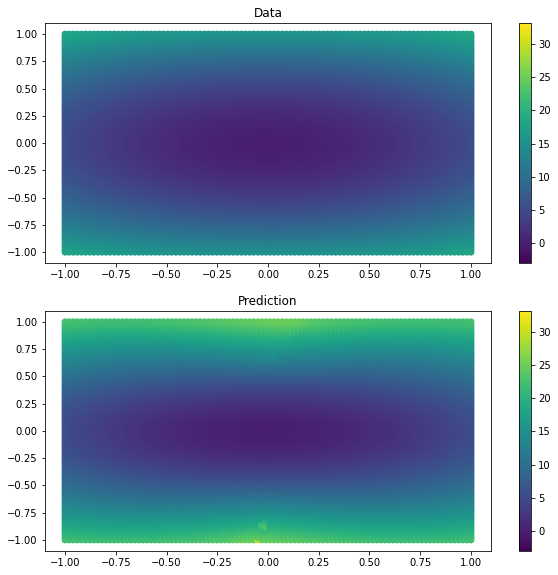

In [22]:
xrange = np.linspace(-1.,1.,100)
xtest = np.array([ [x1,x2, 0.] for x1 in xrange for x2 in xrange ])
    

plt.figure(2,figsize=[10,15])

trange = [ min(y_t_cost),max(y_t_cost) ]
prange = [ min(y_p_cost),max(y_p_cost) ]
vrange = [ min(trange+prange),max(trange+prange)]
vd  = vrange[1]-vrange[0]
vrange = [ vrange[0]-vd*.1, vrange[1]+vd*.1 ]

plt.subplot(3,1,1)
plt.scatter(xtest[:,0],xtest[:,1],c=y_t_cost.flat,vmin=vrange[0],vmax=vrange[1])
plt.colorbar()
plt.title('Data')

plt.subplot(3,1,2)
plt.scatter(xtest[:,0],xtest[:,1],c=y_p_cost.flat,vmin=vrange[0],vmax=vrange[1])
plt.colorbar()
plt.title('Prediction')


Text(0.5, 1.0, 'Prediction')

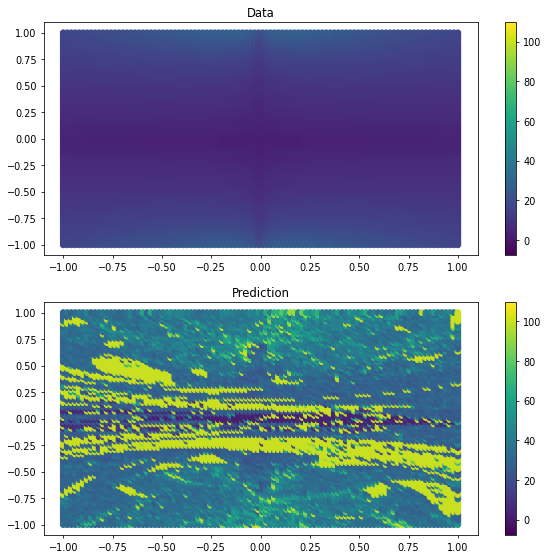

In [27]:
xrange = np.linspace(-1.,1.,100)
xtest = np.array([ [x1,x2, 0.] for x1 in xrange for x2 in xrange ])
    

plt.figure(2,figsize=[10,15], dpi=70)

trange = [ min(y_t_iters),max(y_t_iters) ]
prange = [ min(y_p_iters),max(y_p_iters) ]
vrange = [ min(trange+prange),max(trange+prange)]
vd  = vrange[1]-vrange[0]
vrange = [ vrange[0]-vd*.1, vrange[1]+vd*.1 ]

plt.subplot(3,1,1)
plt.scatter(xtest[:,0],xtest[:,1],c=y_t_iters.flat,vmin=vrange[0],vmax=vrange[1])
plt.colorbar()
plt.title('Data')

plt.subplot(3,1,2)
plt.scatter(xtest[:,0],xtest[:,1],c=y_p_iters.flat,vmin=vrange[0],vmax=vrange[1])
plt.colorbar()
plt.title('Prediction')

In [30]:
mse_iters = np.abs(y_t_iters - y_p_iters)

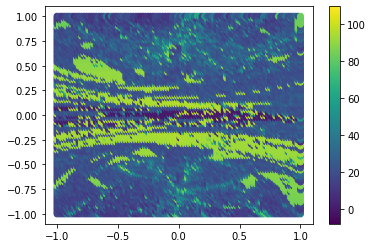

In [32]:
plt.scatter(xtest[:,0],xtest[:,1],c=mse_iters,vmin=vrange[0],vmax=vrange[1])
plt.colorbar()

In [33]:
mse_iters

array([[17],
       [17],
       [18],
       ...,
       [84],
       [83],
       [83]])

In [ ]:
plt.plot(y_t_iters)

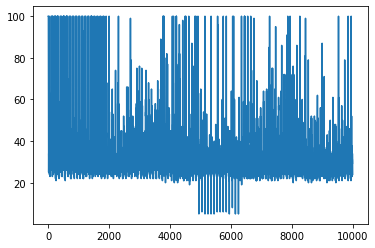

In [20]:
plt.plot(y_p_iters)

In [100]:
def scatter_data(net):  
    model = crocoddyl.ActionModelUnicycle()
    T = 30
    model.costWeights = np.matrix([1,1]).T
    modelValueTerminal = UnicycleTerminal(net)
    N_iterations = []
    N_cost = []
    C_iterations = []
    C_cost = []

    x = np.linspace(-2, 2., 100)
    y = np.linspace(-2, 2., 100)
    X,Y = np.meshgrid(x,y)

    for x, y in zip(np.ravel(X), np.ravel(Y)):
        xyz = [x,y,0.]

        problem = crocoddyl.ShootingProblem(m2a(xyz).T, [ model ] * T, modelValueTerminal)
        ddp = crocoddyl.SolverDDP(problem)
        ddp.solve()
        N_iterations.append([ddp.iter])
        N_cost.append([ddp.cost])


        problem2 = crocoddyl.ShootingProblem(m2a(xyz).T, [ model ] * T, model)
        ddp2 = crocoddyl.SolverDDP(problem2)
        ddp2.solve()
        C_iterations.append([ddp2.iter])
        C_cost.append([ddp2.cost])
        
    return N_iterations, N_cost, C_iterations, C_cost   

In [101]:
ni, nc , ci, cc = scatter_data(net)

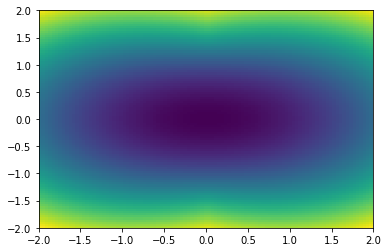

In [104]:
# for the neural net
x1 = np.linspace(-2, 2., 100)
y1 = np.linspace(-2, 2., 100)
X,Y = np.meshgrid(x1,y1)
Z = np.array(cc).reshape(X.shape)
plt.pcolormesh(X, Y, Z)
plt.show()

In [105]:
ni

[[31],
 [31],
 [27],
 [32],
 [35],
 [34],
 [100],
 [100],
 [100],
 [100],
 [100],
 [100],
 [100],
 [100],
 [100],
 [100],
 [100],
 [100],
 [100],
 [100],
 [100],
 [59],
 [100],
 [59],
 [69],
 [73],
 [71],
 [65],
 [74],
 [65],
 [62],
 [68],
 [65],
 [63],
 [64],
 [39],
 [69],
 [64],
 [97],
 [55],
 [51],
 [100],
 [80],
 [100],
 [53],
 [100],
 [65],
 [65],
 [51],
 [53],
 [54],
 [54],
 [48],
 [45],
 [97],
 [54],
 [56],
 [43],
 [58],
 [57],
 [53],
 [48],
 [44],
 [100],
 [46],
 [62],
 [60],
 [36],
 [71],
 [44],
 [38],
 [37],
 [43],
 [37],
 [39],
 [67],
 [35],
 [36],
 [35],
 [46],
 [33],
 [30],
 [28],
 [35],
 [36],
 [30],
 [29],
 [48],
 [63],
 [36],
 [32],
 [41],
 [32],
 [51],
 [34],
 [39],
 [30],
 [48],
 [54],
 [35],
 [34],
 [38],
 [35],
 [100],
 [100],
 [100],
 [100],
 [100],
 [100],
 [100],
 [100],
 [100],
 [100],
 [100],
 [100],
 [100],
 [100],
 [100],
 [100],
 [100],
 [100],
 [54],
 [100],
 [71],
 [63],
 [100],
 [64],
 [100],
 [100],
 [51],
 [51],
 [51],
 [35],
 [73],
 [100],
 [77],
 [100

ValueError: 'c' argument has 10000 elements, which is inconsistent with 'x' and 'y' with size 100.

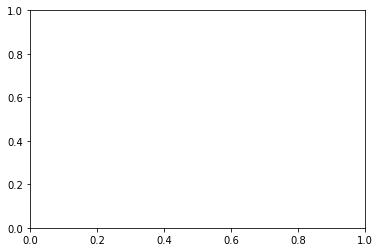

In [109]:
plt.scatter(x1, y1, c = ni)

In [60]:
def scatter_loss_function(cost = True):
    """
    Returns a scatter plot of the loss function
    """
    
    min_x, max_x, dim_x = (-2, 2, 100)
    min_y, max_y, dim_y = (-2, 2, 100)
    x = np.linspace(min_x, max_x, dim_x)
    y = np.linspace(min_y, max_y, dim_y)
    X,Y = np.meshgrid(x,y)
    
    z = np.array([crocoddyl_cost(x,y, cost) for (x,y) in zip(np.ravel(X), np.ravel(Y))])
    Z = z.reshape(X.shape)
    
    plt.pcolormesh(X,Y,Z)    
    plt.xticks(np.arange(-2., 2.1, step=1))
    plt.yticks(np.arange(-2., 2.1, step=1))
    cbar = plt.colorbar()
    
    if cost:
        cbar.set_label('Cost')
        plt.title("Plain Crocoddyl Cost")
        plt.savefig("Crocoddyl Value Function.png")
        
    
    plt.show()
    

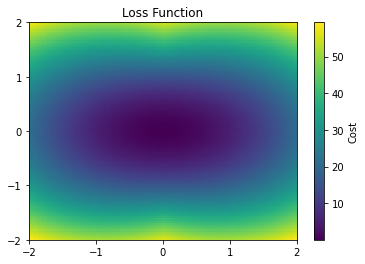

In [58]:
scatter_loss_function()

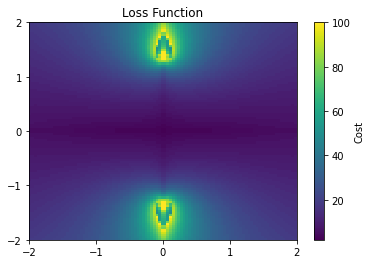

In [61]:
scatter_loss_function(False)

In [68]:
def crocoddyl_neural_net(X, Y, net, cost = True):
    xyz = [X, Y, 0]
    model = crocoddyl.ActionModelUnicycle()
    modelTerminal = UnicycleTerminal(net)
    T = 30
    model.costWeights = np.matrix([1,1]).T

    problem = crocoddyl.ShootingProblem(m2a(xyz).T, [ model ] * T, modelTerminal)
    ddp = crocoddyl.SolverDDP(problem)
    ddp.solve()
    if cost:
        return ddp.cost
    else:
        return ddp.iter

In [69]:
def scatter_neural_function(net,cost = True):
    """
    Returns a scatter plot of the loss function
    """
    
    min_x, max_x, dim_x = (-2, 2, 100)
    min_y, max_y, dim_y = (-2, 2, 100)
    x = np.linspace(min_x, max_x, dim_x)
    y = np.linspace(min_y, max_y, dim_y)
    X,Y = np.meshgrid(x,y)
    
    z = np.array([crocoddyl_neural_net(x,y,net,cost) for (x,y) in zip(np.ravel(X), np.ravel(Y))])
    Z = z.reshape(X.shape)
    
    plt.pcolormesh(X,Y,Z)    
    plt.xticks(np.arange(-2., 2.1, step=1))
    plt.yticks(np.arange(-2., 2.1, step=1))
    plt.title("Loss Function")
    cbar = plt.colorbar()
    cbar.set_label('Cost')
    #plt.savefig("Loss.png")
    plt.show()

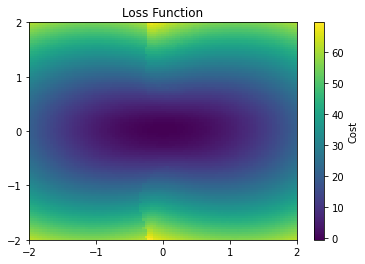

In [70]:
scatter_neural_function(net, True)

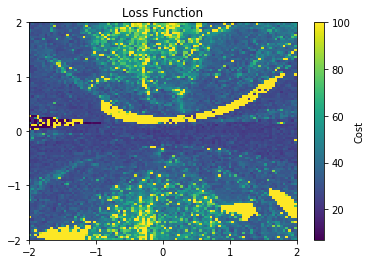

In [71]:
scatter_neural_function(net, False)

In [ ]:
xrange = np.linspace(-1,1,100)
xtest = np.array([ [x1,x2] for x1 in xrange for x2 in xrange ])
ytest = datagen(xtest)
ypred = model(torch.Tensor(xtest)).detach().numpy()
plt.figure(2,figsize=[10,15])

trange = [ min(ytest),max(ytest) ]
prange = [ min(ypred),max(ypred) ]
vrange = [ min(trange+prange),max(trange+prange)]
vd  = vrange[1]-vrange[0]
vrange = [ vrange[0]-vd*.1, vrange[1]+vd*.1 ]

plt.subplot(3,1,1)
plt.scatter(xtest[:,0],xtest[:,1],c=ytest.flat,vmin=vrange[0],vmax=vrange[1])
plt.colorbar()
plt.title('Data')

plt.subplot(3,1,2)
plt.scatter(xtest[:,0],xtest[:,1],c=ypred.flat,vmin=vrange[0],vmax=vrange[1])
plt.colorbar()
plt.title('Prediction')

plt.subplot(3,1,3)
plt.scatter(xtest[:,0],xtest[:,1],c=(ypred-ytest).flat)
plt.colorbar()    